## 练习

1. 尝试说明独热编码等价于为每个对象选择不同的嵌入表示。
1. 通过调整超参数（如迭代周期数、隐藏单元数、小批量数据的时间步数、学习率等）来改善困惑度。
    * 困惑度可以降到多少？
    * 用可学习的嵌入表示替换独热编码，是否会带来更好的表现？
    * 如果用H.G.Wells的其他书作为数据集时效果如何，
      例如[*世界大战*](http://www.gutenberg.org/ebooks/36)？
1. 修改预测函数，例如使用采样，而不是选择最有可能的下一个字符。
    * 会发生什么？
    * 调整模型使之偏向更可能的输出，例如，当$\alpha > 1$，从$q(x_t \mid x_{t-1}, \ldots, x_1) \propto P(x_t \mid x_{t-1}, \ldots, x_1)^\alpha$中采样。
1. 在不裁剪梯度的情况下运行本节中的代码会发生什么？
1. 更改顺序划分，使其不会从计算图中分离隐状态。运行时间会有变化吗？困惑度呢？
1. 用ReLU替换本节中使用的激活函数，并重复本节中的实验。我们还需要梯度裁剪吗？为什么？

### 练习1. 独热编码与嵌入表示的等价性

独热编码可以被视为一种特殊的嵌入表示，其中嵌入矩阵是一个单位矩阵。在这种情况下，每个词元的嵌入向量是一个在对应位置有一个1，其余位置为0的向量。这意味着每个词元都有一个唯一的、不共享的表示。使用可学习的嵌入表示时，每个词元的表示可以在训练过程中被优化，以捕获更多的语义信息。

困惑度 1.0


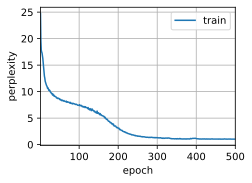

In [1]:
##练习2
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 数据加载
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

# 获取模型参数
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

# 初始化RNN状态
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

# RNN模型
def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H = state[0]  # 修改这里，以正确引用state中的隐藏状态
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)  # 确保返回的也是一个元组

# RNN模型类
class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

# 超参数
num_hiddens = 512
lr = 1
num_epochs = 500
device = d2l.try_gpu()

# 实例化模型
net = RNNModelScratch(len(vocab), num_hiddens, device, get_params, init_rnn_state, rnn)

# 定义梯度裁剪
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

# 训练一个迭代周期
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    state = None
    metric = d2l.Accumulator(2)  # 训练损失之和, 词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 初始化或重新初始化状态
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            state = (state[0].detach(),)  # 修改这里，确保state是一个元组
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1])

# 训练模型
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        perplexity = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        animator.add(epoch + 1, [perplexity])
    print(f'困惑度 {perplexity:.1f}')

# 训练网络
train_ch8(net, train_iter, vocab, lr, num_epochs, device)

困惑度 1.2
time traveller fou snick yop comen adrivis you pryp an inguyst al


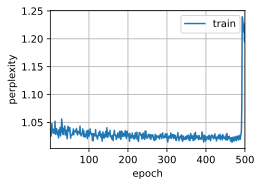

In [2]:
## 练习3
# 修改后的预测函数，使用采样
def predict_ch8(prefix, num_preds, net, vocab, device, temperature=1.0):
    """在`prefix`后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        # 使用temperature调整概率分布
        probs = F.softmax(y / temperature, dim=1)
        idx = torch.multinomial(probs, num_samples=1).item()
        outputs.append(idx)
    return ''.join([vocab.idx_to_token[i] for i in outputs])

# 训练网络
train_ch8(net, train_iter, vocab, lr, num_epochs, device)

# 使用修改后的预测函数生成文本
print(predict_ch8('time traveller ', 50, net, vocab, device, temperature=1.0))

困惑度 14720488040655722.0


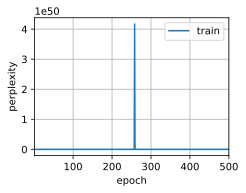

In [4]:
## 练习4
# 超参数
num_hiddens = 512
lr = 1
num_epochs = 500
device = d2l.try_gpu()

# 实例化模型
net = RNNModelScratch(len(vocab), num_hiddens, device, get_params, init_rnn_state, rnn)

# 训练一个迭代周期
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    state = None
    metric = d2l.Accumulator(2)  # 训练损失之和, 词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            state = (state[0].detach(),)  # 修改这里，确保state是一个元组
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            # grad_clipping(net, 1)  # 注释掉梯度裁剪
            updater.step()
        else:
            l.backward()
            # grad_clipping(net, 1)  # 注释掉梯度裁剪
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1])

# 训练网络
train_ch8(net, train_iter, vocab, lr, num_epochs, device)

Epoch 10, Perplexity 13.8, Time 0.24 sec
困惑度 13.8


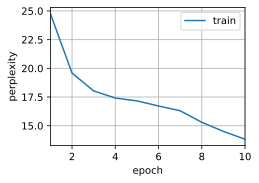

In [7]:
## 练习5
import math
import time
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 数据加载
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

# 获取模型参数
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

# 初始化RNN状态
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

# RNN模型
def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

# RNN模型类
class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

# 定义梯度裁剪
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

# 训练一个迭代周期
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    state = None
    metric = d2l.Accumulator(2)  # 训练损失之和, 词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            # 为了避免错误，创建新的状态变量
            if isinstance(state, tuple):
                state = (state[0].detach(),)
            else:
                state = state.detach()
        # 剩下的代码不变
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1])

# 训练模型
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        start = time.time()
        perplexity = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        animator.add(epoch + 1, [perplexity])
        print(f'Epoch {epoch + 1}, Perplexity {perplexity:.1f}, Time {time.time() - start:.2f} sec')
    print(f'困惑度 {perplexity:.1f}')

# 超参数
num_hiddens = 512
lr = 1
num_epochs = 10  # 为了测试，减少迭代次数
device = d2l.try_gpu()

# 实例化模型并训练
net = RNNModelScratch(len(vocab), num_hiddens, device, get_params, init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, device)


Epoch 500, Perplexity 1.0, Time 0.27 sec
困惑度 1.0


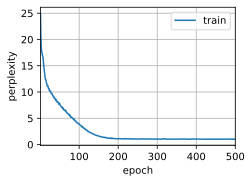

In [8]:
## 练习 6
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 数据加载
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

# 获取模型参数
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

# 初始化RNN状态
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

# 使用ReLU激活函数的RNN模型
def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = F.relu(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

# 超参数
num_hiddens = 512
lr = 1
num_epochs = 500
device = d2l.try_gpu()

# 实例化模型并训练
net = RNNModelScratch(len(vocab), num_hiddens, device, get_params, init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, device)
